# FAST'25 Artifact Evaluation - Plotter


In [3]:
# Prelude
# RUN THIS CELL BEFORE ANYTHING ELSE!

import os, glob, codecs
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from IPython.display import HTML, display


EVALUATED_SYSTEMS = [
    'Cas',
    'Drtm',
    'Dslr',
    'Mcs',
    'Rmarw',
    'Rpc',
    'Handlock',
]


def fixname(name):
    """
    ShiftLock was originally named Handlock, which virtually exists everywhere in the code.
    So we do not fix it everywhere.
    Instead, we use this function to fix the name so that AE reviewers are not confused.
    """
    if isinstance(name, str):
        return name.replace('Handlock', 'ShiftLock')
    if isinstance(name, list):
        return list(fixname(n) for n in name)
    return name


class TimerResult:
    def __init__(self):
        self.name = ""
        self.avg = 0
        self.p50 = 0
        self.p90 = 0
        self.p99 = 0
    
    def __str__(self):
        return f'{self.name} avg={self.avg} p50={self.p50} p90={self.p90} p99={self.p99}'
    
    @classmethod
    def average(cls, timers):
        n = len(timers)
        if n == 0:
            return None
        
        avg = cls()
        avg.name = timers[0].name
        avg.avg = sum(t.avg for t in timers) / n
        avg.p50 = sum(t.p50 for t in timers) / n
        avg.p90 = sum(t.p90 for t in timers) / n
        avg.p99 = sum(t.p99 for t in timers) / n
        return avg


def parse_time(s):
    suffix = s[-2:]
    number = float(s[:-2])
    if suffix == 'ns':
        return number
    elif suffix == 'µs':
        return number * 1000
    elif suffix == 'ms':
        return number * 1000000
    else:
        print(f'Error: invalid time suffix: {suffix}')
        return -1


class Data:
    def __init__(self, path, **kwargs):
        if not path:
            return

        self.path = [path]
        self.throughput = 0
        self.total = 0
        self.latency_cdfs = []
        self.timers = []
        self.conswrts = [0]
        self.conswrt_avg = -1

        cur_state = None
        cur = None
        for line in codecs.open(path, encoding='utf-8').readlines():
            line = line.strip()
            if not line:
                continue

            if cur_state is None:
                if line == '0,0':
                    # '0,0' marks the beginning of a latency CDF.
                    cur_state = 'latency_cdf'
                    cur = [0] * 100
                elif line[:7] == '10.0.2.':
                    # '10.0.2.11x:' marks an output line in FT throughput experiment.
                    cur_state = 'ft_thpt'
                elif line[:5] == 'Timer':
                    # 'Timer X xxxxx:' marks the beginning of a timer.
                    timer_id = int(line.split(' ')[1])
                    assert timer_id == len(self.timers)
                    cur_state = 'timer'
                    cur = TimerResult()
                    cur.name = line.split(' ')[2][:-1]
                elif line[:7] == 'conswrt':
                    # 'conswrt X' marks a conswrt record.
                    conswrt_id = line.split(' ')[1][:-1]
                    if conswrt_id == 'avg':
                        self.conswrt_avg = float(line.split(':')[1].strip())
                    else:
                        assert int(conswrt_id) == len(self.conswrts)
                        self.conswrts.append(int(line.split(':')[1].strip()))

                continue

            if cur_state == 'latency_cdf':
                tokens = line.split(',')
                if len(tokens) > 3:
                    print(f'Error: invalid line when parsing CDF: {line}')
                    return
                if tokens[0] == 'total':
                    if len(tokens) >= 3:
                        total = int(tokens[1])
                        self.total += total
                        thpt = float(tokens[2])
                        self.throughput += thpt
                    else:
                        thpt = float(tokens[1])
                        self.throughput += thpt
                    self.latency_cdfs.append(cur)
                    cur_state = None
                else:
                    cur[int(tokens[0])] = int(tokens[1])
            elif cur_state == 'ft_thpt':
                tokens = line.split(':')
                if len(tokens) >= 3:
                    ops = float(tokens[-1].strip().split(' ')[0])
                    self.throughput += ops
            elif cur_state == 'timer':
                tokens = line.split(' ')
                if tokens[0] == 'Average:':
                    cur.avg = parse_time(tokens[1])
                elif tokens[0] == '50th':
                    cur.p50 = parse_time(tokens[2])
                elif tokens[0] == '90th':
                    cur.p90 = parse_time(tokens[2])
                elif tokens[0] == '99th':
                    cur.p99 = parse_time(tokens[2])
                    self.timers.append(cur)
                    cur_state = None

    def __str__(self):
        return f'{self.path} thpt={self.throughput} conswrt_avg={self.conswrt_avg} latency_cdfs={self.latency_cdfs}'

    @staticmethod
    def sum(data):
        n = len(data)
        if n == 0:
            return None
        
        avg = Data('')
        avg.path = list(d.path[0] for d in data)
        avg.total = sum(d.total for d in data)
        avg.throughput = sum(d.throughput for d in data)
        avg.latency_cdfs = []
        for i in range(len(data[0].latency_cdfs)):
            avg_cdf = list(sum(l) / n for l in zip(*[d.latency_cdfs[i] for d in data]))
            avg.latency_cdfs.append(avg_cdf)
            
        timercnt = min(len(d.timers) for d in data)
        avg.timers = list(TimerResult.average([d.timers[i] for d in data]) for i in range(timercnt))
        avg.conswrts = list(sum(d.conswrts[i] for d in data) / n for i in range(min(len(d.conswrts) for d in data)))
        avg.conswrt_avg = sum(d.conswrt_avg for d in data) / n

        return avg
        

def collect_dir(dir, **kwargs) -> Data:
    '''
    Collect data recorded in a directory.
    '''
    data = []
    for file in glob.glob(str(dir / '*.txt')):
        # Special: skip counters.txt file.
        if 'counters.txt' in file:
            continue
        data.append(Data(file, **kwargs))
    
    return Data.sum(data)


def parse_counter_file(path):
    line = open(path).readline().strip()
    tokens = line.split(' ')
    return int(tokens[0]), int(tokens[1])


## Figurse 3, 4

These two figures require that you run `exp1.sh` beforehand.

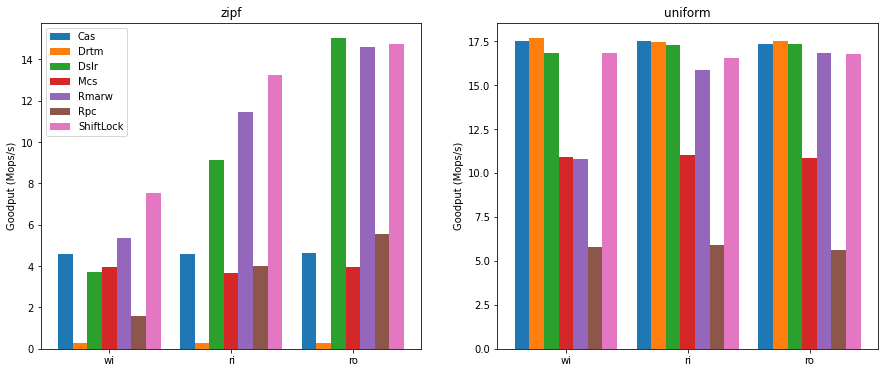

In [8]:
try:
    data_dir = Path(os.getcwd()).parent.parent / 'data' / 'exp1'
    skewness = ['zipf', 'uniform']
    rw_ratio = ['wi', 'ri', 'ro']

    plt.figure(figsize=(15, 6))
    width = 0.12
    x = np.arange(len(rw_ratio))

    for (i, sk) in enumerate(skewness):
        plt.subplot(121 + i)
        for (j, lock) in enumerate(EVALUATED_SYSTEMS):
            series = []
            for rw in rw_ratio:
                res_file = f'{data_dir}/{lock}-{sk}-{rw}'
                if not os.path.exists(res_file):
                    print(f"Results for {res_file} not found. Skipping...")
                    continue
                data = collect_dir(Path(res_file))
                series.append(data.throughput / 1e6)
            plt.bar(x + (j - 3) * width, series, width, label=fixname(lock))
        plt.ylabel('Goodput (Mops/s)')
        plt.title(sk)
        plt.xticks(x, rw_ratio)

        if i == 0:
            plt.legend()
    
    plt.show()

except Exception as e:
    print(e)
    print('Error: failed to plot Figure 3.')

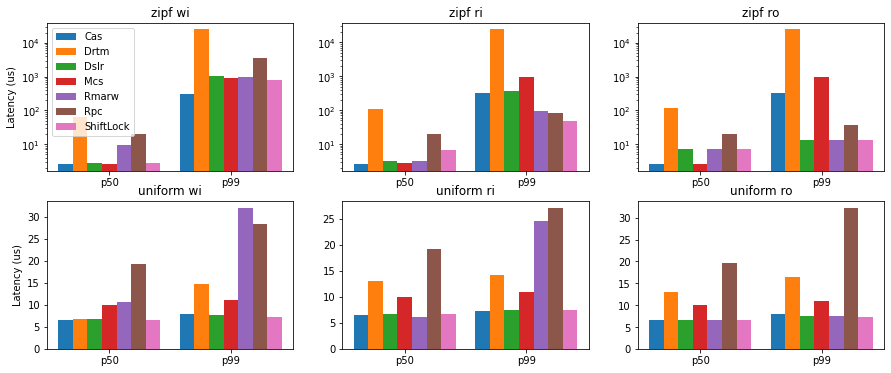

In [9]:
try:
    data_dir = Path(os.getcwd()).parent.parent / 'data' / 'exp1'
    skewness = ['zipf', 'uniform']
    rw_ratio = ['wi', 'ri', 'ro']
    
    plt.figure(figsize=(15, 6))
    width = 0.12
    x = np.arange(2)

    for (i, sk) in enumerate(skewness):
        for (j, rw) in enumerate(rw_ratio):
            plt.subplot(230 + i * 3 + j + 1)
            for (k, lock) in enumerate(EVALUATED_SYSTEMS):
                res_file = f'{data_dir}/{lock}-{sk}-{rw}'
                if not os.path.exists(res_file):
                    print(f"Results for {res_file} not found. Skipping...")
                    continue
                data = collect_dir(Path(res_file))
                plt.bar(x + (k - 3) * width, [data.latency_cdfs[0][50] / 1e3, data.latency_cdfs[0][99] / 1e3], width, label=fixname(lock))
            if j == 0:
                plt.ylabel('Latency (us)')
            if i == 0:
                plt.yscale('log')
            plt.title(f'{sk} {rw}')
            plt.xticks(x, ['p50', 'p99'])
            if i == 0 and j == 0:
                plt.legend()
    
    plt.show()

except Exception as e:
    print(e)
    print('Error: failed to plot Figure 4.')

## Figure 5

This figure requires that you run `exp2.sh` beforehand.

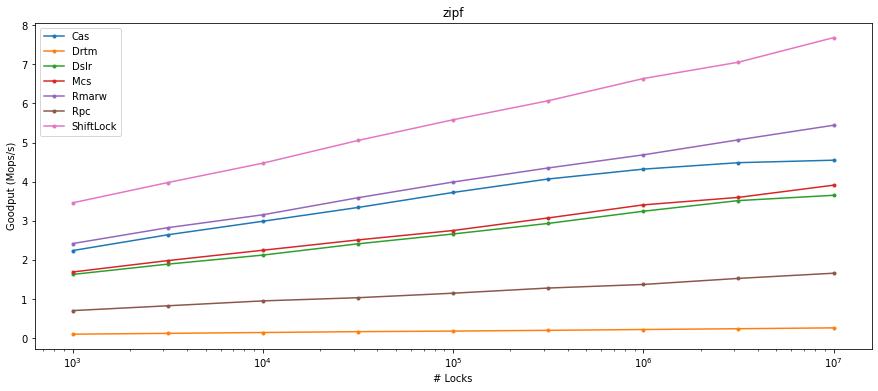

In [4]:
try:
    data_dir = Path(os.getcwd()).parent.parent / 'data' / 'exp2'
    skewness = ['zipf']
    nums = [1000, 3162, 10000, 31623, 100000, 316228, 1000000, 3162278, 10000000]
    
    plt.figure(figsize=(15, 6))

    for (i, sk) in enumerate(skewness):
        plt.subplot(100 + len(skewness) * 10 + i + 1)
        for lock in EVALUATED_SYSTEMS:
            series = []
            for num in nums:
                res_file = f'{data_dir}/{sk}-{lock}-{num}'
                if not os.path.exists(res_file):
                    print(f"Results for {res_file} not found. Skipping...")
                    continue
                data = collect_dir(Path(res_file))
                series.append(data.throughput / 1e6)
            plt.plot(nums, series, label=fixname(lock), marker='.')
        plt.xscale('log')
        plt.xlabel('# Locks')
        plt.ylabel('Goodput (Mops/s)')
        plt.title(sk)
        
        if i == 0:
            plt.legend()
    
    plt.show()

except Exception as e:
    print(e)
    print('Error: failed to plot Figure 5.')

## Figure 6

This figure requires that you run `exp3.sh` beforehand.

**NOTE:** In rare cases this plot may output negative bars due to hardware counter wrap-around.
If this happens, please re-run `exp3.sh`.

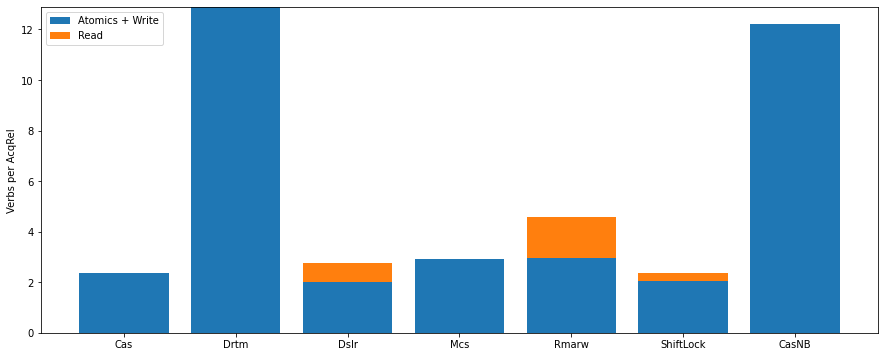

In [ ]:
try:
    data_dir = Path(os.getcwd()).parent.parent / 'data' / 'exp3'
    evaluated_systems = list(filter(lambda x: x != 'Rpc', EVALUATED_SYSTEMS)) + ['CasNB']
    
    plt.figure(figsize=(15, 6))
    atomics = []
    reads = []

    for lock in evaluated_systems:
        res_file = f'{data_dir}/{lock}'
        total = collect_dir(Path(res_file)).total
        a, r = parse_counter_file(f'{res_file}/counters.txt')
        atomics.append(a / total)
        reads.append(r / total)
    
    evaluated_systems = fixname(evaluated_systems)
    plt.bar(evaluated_systems, atomics, label='Atomics + Write')
    plt.bar(evaluated_systems, reads, bottom=atomics, label='Read')
    plt.ylabel('Verbs per AcqRel')
    plt.legend()
    plt.show()

except Exception as e:
    print(e)
    print('Error: failed to plot Figure 6.')

## Figure 7

This figure requires that you run `exp4.sh` beforehand.

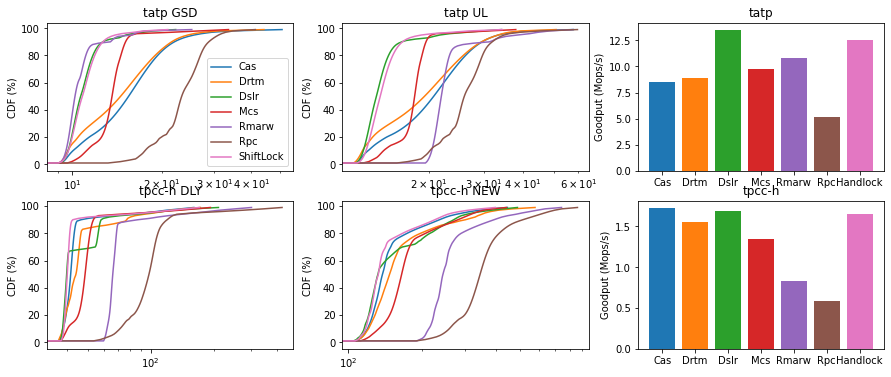

In [11]:
try:
    data_dir = Path(os.getcwd()).parent.parent / 'data' / 'exp4'
    workloads = ['tatp', 'tpcc-h']
    txns = {
        'tatp': [
            (0, 'GSD'),
            (4, 'UL'),
        ],
        'tpcc-h': [
            (3, 'DLY'),
            (0, 'NEW'),
        ],
    }

    plt.figure(figsize=(15, 6))

    dataset = {}
    for wl in workloads:
        dataset[wl] = {}
        for lock in EVALUATED_SYSTEMS:
            res_file = f'{data_dir}/{wl}-{lock}'
            if not os.path.exists(res_file):
                print(f"Results for {res_file} not found. Skipping...")
                continue
            dataset[wl][lock] = collect_dir(Path(res_file))
    
    for (i, wl) in enumerate(workloads):
        # Latency CDFs
        for (j, (txnid, label)) in enumerate(txns[wl]):
            plt.subplot(230 + i * 3 + j + 1)
            for lock in EVALUATED_SYSTEMS:
                series = dataset[wl][lock].latency_cdfs[txnid]
                for k in range(len(series)):
                    series[k] = series[k] / 1e3
                plt.plot(series, np.arange(100), label=fixname(lock))
            
            plt.title(f'{wl} {label}')
            plt.xscale('log')
            plt.ylabel('CDF (%)')

            if i == 0 and j == 0:
                plt.legend()
        
        # Throughput bars
        plt.subplot(230 + i * 3 + 3)
        for lock in EVALUATED_SYSTEMS:
            plt.bar(lock, dataset[wl][lock].throughput / 1e6, label=fixname(lock))
        plt.ylabel('Goodput (Mops/s)')
        plt.title(wl)

    plt.show()

except Exception as e:
    print(e)
    print('Error: failed to plot Figure 7.')

## Figure 8

This figure requires that you run `exp5.sh` beforehand.

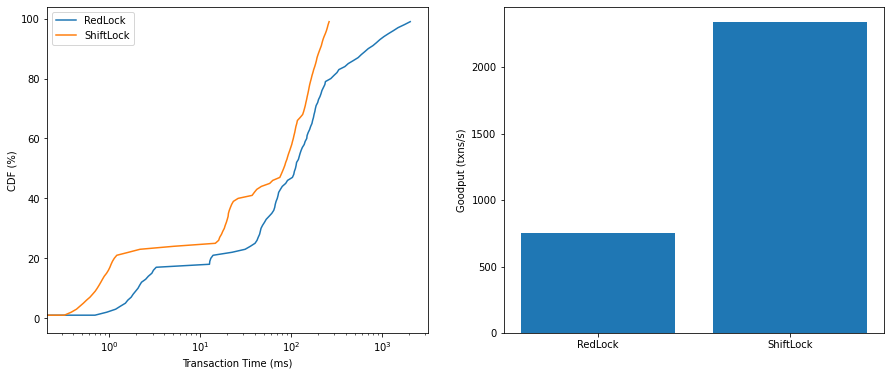

In [4]:
try:
    data_dir = Path(os.getcwd()).parent.parent / 'data' / 'exp5'
    locks = ['RedLock', 'Handlock']
    
    data = {}
    for lock in locks:
        res_file = f'{data_dir}/{lock}'
        data[lock] = collect_dir(Path(res_file))

    plt.figure(figsize=(15, 6))

    # Latency CDF
    plt.subplot(121)
    for lock in locks:
        series = data[lock].latency_cdfs[0]
        for i in range(len(series)):
            series[i] = series[i] / 1e6
        plt.plot(series, np.arange(100), label=fixname(lock))
    plt.xscale('log')
    plt.ylabel('CDF (%)')
    plt.xlabel('Transaction Time (ms)')
    plt.legend()

    # Throughput bars
    plt.subplot(122)
    thpts = list(data[lock].throughput for lock in locks)
    plt.bar(fixname(locks), thpts)
    plt.ylabel('Goodput (txns/s)')

    plt.show()
    
except Exception as e:
    print(e)
    print('Error: failed to plot Figure 8.')

## Tables 3, 4

These tables require that you run `exp6.sh` beforehand.

In [8]:
try:
    data_dir = Path(os.getcwd()).parent.parent / 'data' / 'exp6'
    
    table3_dir = data_dir / 'table3'
    nthreads = [1, 4, 8, 16, 24, 32, 40, 48]
    clients = list(map(lambda x: x * 5, nthreads))
    data3 = []
    for n in nthreads:
        res_file = f'{table3_dir}/{n}'
        if not os.path.exists(res_file):
            print(f"Results for {res_file} not found. Skipping...")
            continue
        data = collect_dir(Path(res_file))
        data3.append([
            data.timers[0].avg / 1e3,
            data.timers[2].avg / 1e3,
            data.timers[3].avg / 1e3,
            data.timers[4].avg / 1e3,
            data.timers[1].avg / 1e3,
            data.timers[5].avg / 1e3,
            data.timers[7].avg / 1e3,
            (data.timers[9].avg + data.timers[10].avg) / 1e3,
        ])
    columns3 = ['AcqW.IA', 'AcqW.NP', 'AcqW.WP', 'AcqW.WR'] + ['AcqR.IA', 'AcqR.WW'] + ['Rel.IA', 'Rel.NS']
    table3 = pd.DataFrame(data3, columns=columns3, index=clients)
    print("Table 3")
    display(HTML(table3.to_html()))

except Exception as e:
    print(e)
    print('Error: failed to plot Table 3.')

Table 3


,AcqW.IA,AcqW.NP,AcqW.WP,AcqW.WR,AcqR.IA,AcqR.WW,Rel.IA,Rel.NS
5,2.3712,0.1872,0.5318,0.7626,2.3266,0.0214,2.3470,0.0000
20,2.4804,0.9924,1.6678,1.0714,2.4184,0.1788,2.4396,0.0322
40,2.6346,1.7386,3.6864,0.9642,2.4868,0.9494,2.4902,0.1332
80,3.2618,2.0892,8.5572,0.7414,2.7074,4.1512,2.7542,0.2156
120,3.6618,2.1928,16.8828,0.6924,3.1260,9.1740,3.2048,0.2618
160,4.3812,2.2660,28.6662,0.7632,3.7972,15.4468,3.8956,0.3000
200,4.7268,2.3282,42.8294,0.7570,4.3418,21.9956,4.4196,0.3302
240,6.3462,2.3498,49.2610,0.9518,5.7814,27.6628,5.7642,0.3694


In [ ]:
try:
    data_dir = Path(os.getcwd()).parent.parent / 'data' / 'exp6'
    
    table4_dir = data_dir / 'table4'
    evaluated_systems = ['Handlock', 'Cas', 'CasNB', 'Dslr']
    data4 = []
    for lock in evaluated_systems:
        res_file = f'{table4_dir}/{lock}'
        if not os.path.exists(res_file):
            print(f"Results for {res_file} not found. Skipping...")
            continue
        data = collect_dir(Path(res_file))

        row = [
            data.timers[0].avg / 1e3,
            (data.timers[2].avg + data.timers[3].avg + data.timers[4].avg) / 1e3,
            data.timers[1].avg / 1e3,
            data.timers[5].avg / 1e3,
            data.timers[7].avg / 1e3,
            (data.timers[9].avg + data.timers[10].avg) / 1e3,
        ]
        if 'Cas' in lock:
            row[2] = row[0]
        if lock == 'CasNB':
            row[1] = row[3]
        data4.append(row)

    columns4 = ['AcqW.IA', 'AcqW.NP+WP+WR/RT'] + ['AcqR.IA', 'AcqR.WW/RT'] + ['Rel.IA', 'Rel.NS']
    table4 = pd.DataFrame(data4, columns=columns4, index=fixname(evaluated_systems))
    print("Table 4")
    display(HTML(table4.to_html()))

except Exception as e:
    print(e)
    print('Error: failed to plot Table 4.')

## Figure 9

This figure requires that you run `exp7.sh` beforehand.

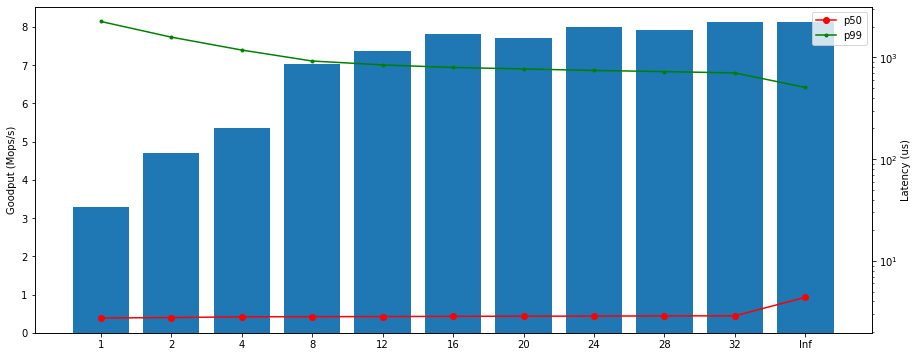

In [7]:
try:
    data_dir = Path(os.getcwd()).parent.parent / 'data' / 'exp7'
    conswrts = []
    for d in glob.glob(str(data_dir / '*')):
        conswrts.append(d.split('/')[-1])
    conswrts = sorted(conswrts, key=lambda x: int(x))

    plt.figure(figsize=(15, 6))

    thpt = []
    lat50 = []
    lat99 = []
    for c in conswrts:
        res_file = f'{data_dir}/{c}'
        if not os.path.exists(res_file):
            print(f"Results for {res_file} not found. Skipping...")
            continue
        data = collect_dir(Path(res_file))
        thpt.append(data.throughput / 1e6)
        lat50.append(data.latency_cdfs[0][50] / 1e3)
        lat99.append(data.latency_cdfs[0][99] / 1e3)
    
    conswrts[-1] = 'Inf'
    plt.bar(np.arange(len(conswrts)), thpt)
    plt.xticks(np.arange(len(conswrts)), conswrts)
    plt.ylabel('Goodput (Mops/s)')

    ax = plt.twinx()
    ax.plot(np.arange(len(conswrts)), lat50, label='p50', color='r', marker='o')
    ax.plot(np.arange(len(conswrts)), lat99, label='p99', color='g', marker='.')
    ax.set_yscale('log')
    ax.set_ylabel('Latency (us)')

    plt.legend()
    plt.show()

except Exception as e:
    print(e)
    print('Error: failed to plot Figure 9.')

## Figure 10

This figure requires that you run `exp8.sh` beforehand.

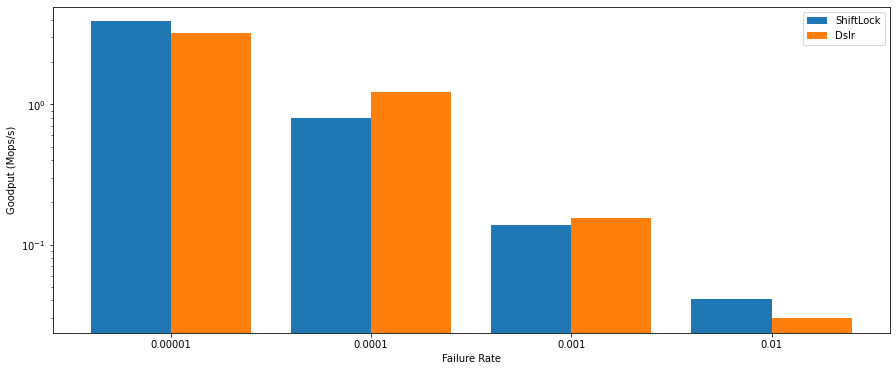

In [19]:
try:
    data_dir = Path(os.getcwd()).parent.parent / 'data' / 'exp8'
    failrate = ['0.00001', '0.0001', '0.001', '0.01']
    locks = ['Handlock', 'Dslr']
    
    plt.figure(figsize=(15, 6))
    width = 0.4
    x = np.arange(len(failrate))

    for (i, lock) in enumerate(locks):
        series = []
        for fr in failrate:
            res_file = f'{data_dir}/{lock}-{fr}.txt'
            if not os.path.exists(res_file):
                print(f"Results for {res_file} not found. Skipping...")
                continue
            data = Data(res_file)
            series.append(data.throughput / 1e6)
    
        plt.bar(x + (i - 0.5) * width, series, width, label=fixname(lock))
    
    plt.ylabel('Goodput (Mops/s)')
    plt.xlabel('Failure Rate')
    plt.yscale('log')
    plt.xticks(x, failrate)
    plt.legend()
    plt.show()

except Exception as e:
    print(e)
    print('Error: failed to plot Figure 10.')